<a href="https://colab.research.google.com/github/gpreston875/Orbit_Determination_and_Propagation/blob/main/POD_and_Prop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Orbit Determination and Propagation Tool**

The purpose of this tool is to provide a first estimate (neglecting perturbations) as to the point of closest approach between two satellites in a given timeframe. This tool uses as inputs the topocentric declination (dec), right ascension (ra), and the local sidereal time (lst) of the tracking station. Gauss' method of preliminary orbit determination, from Curtis, H. (2021), is used to calculate the state vectors of two Earth-bound satellites.

The state vectors are then used to propagate the orbit through time using an rk45 integrator. The point of closest approach is then estimated as the min of these outputs.

#Import Dependencies

In [129]:
import numpy as np
from numpy.linalg import norm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#Gauss' POD Functions

In [130]:
def get_R(lat, lst, H):

  """
  Gets geocentric position vector of the tracking station:

  :param lat: geodetic latitude
  :param lst: local sidereal time
  :param H: height above sea level of the tracking station
  :return: position vector of the tracking station

  """
  coefficient1 = Re  / (np.sqrt(1 - ((2*f-f**2) * np.sin(lat)**2)))\
   + H
  coefficient2 = Re * (1-f)**2 / (np.sqrt(1 - ((2*f-f**2) * np.sin(lat)**2)))\
   + H

  if lat.dtype != np.array:
    lat = np.array([lat])

  RI = coefficient1 * np.cos(lat) * np.cos(lst)
  RJ = coefficient1 * np.cos(lat) * np.sin(lst)
  RK = coefficient2 * np.sin(lat)

  R = np.array([RI[0], RJ[0], RK[0]])

  return R

def get_unit_topocentric_pos_vector(dec, ra):
  """
  Gets the topocentric position unit vector of a satellite:

  :param dec: declination of the satellite
  :param ra: right ascension of the satellite
  :return: topocentric position vector of the satellite (rho_u)

  """

  rho_u = np.array([np.cos(dec) * np.cos(ra),
                 np.cos(dec) * np.sin(ra),
                 np.sin(dec)])

  rho_u = np.array([rho_u[0][0], rho_u[1][0], rho_u[2][0]])

  return rho_u

def F(x, a, b, c):
  """
  get function with linspace values as x
  :param x: linspace of values
  :param a: scalar quantity
  :param b: scalar quantity
  :param c: scalar quantity
  :return: function with linspace values as x

  """

  return x ** 8 + a * x ** 6 + b * x ** 3 + c

def F_dot(x, a, b):
  """
  get derivative of function with linspace values as x
  :param x: linspace of values
  :param a: scalar quantity
  :param b: scalar quantity
  :return: derivative of function with linspace values as x

  """
  return 8*x ** 7 + 6*a * x ** 5 + 3*b * x ** 2

def get_root_x(a, b, c, tol, max_iter):
  """
  get root of function using Newton's method
  :param tol: tolerance
  :param max_iter: maximum number of iterations
  :param a: scalar quantity
  :param b: scalar quantity
  :param c: scalar quantity
  :return: root of function

  """
  x = np.linspace(1, 15000, 100000)
  F_vals = []

  for i in range(0,len(x) - 1):
    F_vals.append(F(x[i], a, b, c))

  F_vals = F(x, a, b, c)

  #PLOT FOR DEBUGGING
  #plt.plot(x,F_vals, label="f")
  #plt.xlabel("x")
  #plt.ylabel("f(x)")
  #plt.title("Gauss Function")
  #plt.legend()
  #plt.grid()
  #plt.show()


  F_min_index = np.argmin(np.abs(F_vals))
  x0 = x[F_min_index]
  x1 = x0 - F(x0, a, b, c) / F_dot(x0, a, b)
  i = 0

  while abs(x1 - x0) > tol and i < max_iter:
    x0 = x1
    x1 = x0 - F(x0, a, b, c) / F_dot(x0, a, b)
    i += 1

  return x1


def get_state_from_angles(dec, ra, lst, time, lat):
  """
  Gets state vector of second measurement using Gauss' method
  :param dec: declination of the satellite (array)
  :param ra: right ascension of the satellite (array)
  :param lst: local sidereal time
  :return: state vector of second measurement
  """

  #Get geocentric position vectors of tracking station

  R1 = get_R(lat, lst[0], H)
  R2 = get_R(lat, lst[1], H)
  R3 = get_R(lat, lst[2], H)

  #Get topocentric position vectors for 3 measurements

  rho1_u = get_unit_topocentric_pos_vector(dec[0], ra[0])
  rho2_u = get_unit_topocentric_pos_vector(dec[1], ra[1])
  rho3_u = get_unit_topocentric_pos_vector(dec[2], ra[2])

  #calculate the time differences
  tau1 = time[0] - time[1]
  tau3 = time[2] - time[1]
  tau = tau3 - tau1

  #Get scalars for calculating slant range
  rho_cross_1 = np.cross(rho2_u, rho3_u)
  rho_cross_2 = np.cross(rho1_u, rho3_u)
  rho_cross_3 = np.cross(rho1_u, rho2_u)
  D0 = np.dot(rho1_u, rho_cross_1)
  D11 = np.dot(R1, rho_cross_1)
  D12 = np.dot(R1, rho_cross_2)
  D13 = np.dot(R1, rho_cross_3)
  D21 = np.dot(R2, rho_cross_1)
  D22 = np.dot(R2, rho_cross_2)
  D23 = np.dot(R2, rho_cross_3)
  D31 = np.dot(R3, rho_cross_1)
  D32 = np.dot(R3, rho_cross_2)
  D33 = np.dot(R3, rho_cross_3)

  A = (1 / D0) * (((-D12) * (tau3 / tau)) + D22 + D32 *(tau1 / tau))

  B = (1 / (6*D0)) * ((D12*(tau3 ** 2 - (tau ** 2)) * (tau3 / tau)) \
                      + D32 * (tau ** 2 - (tau1 ** 2)) * (tau1 / tau))

  E = np.dot(R2, rho2_u)
  a = -(A ** 2 + 2 * A * E + norm(R2) **2)
  b = -2 * mu * B * (A+E)
  c = -(mu ** 2 * B ** 2)

  #Get geocentric distance of satellite at position 2
  r2_mag = get_root_x(a, b, c, 1E-09, 500000)

  #Get topocentric position vector
  rho1 = 1 / D0 * ((6*(D31*(tau1 / tau3) + D21 * (tau / tau3)) * r2_mag ** 3  \
                    + mu * D31 *(tau ** 2 - tau1 ** 2) * (tau1 / tau3))   \
                   / (6*r2_mag ** 3 + mu * (tau ** 2 - tau3 ** 2)) - D11)

  rho2 = A + mu * B / (r2_mag ** 3)

  rho3 = 1 / D0 * ((6*(D13*(tau3 / tau1) - D23 * (tau / tau1)) * r2_mag ** 3  \
                    + mu * D13 *(tau ** 2 - tau3 ** 2) * (tau3 / tau1))   \
                   / (6*r2_mag ** 3 + mu * (tau ** 2 - tau1 ** 2)) - D33)

  #Get geocentric position vectors of satellite positions
  r1 = R1 + norm(rho1)*rho1_u
  r2 = R2 + norm(rho2)*rho2_u
  r3 = R3 + norm(rho3)*rho3_u

  #Get Lagrange Coefficients
  f1 = 1 - 0.5*mu*(tau1**2) / (r2 ** 3)
  f3 = 1 - 0.5*mu*(tau3**2) / (r2 ** 3)
  g1 = tau1 - (1/6)*mu*(tau1**3) / (r2 ** 3)
  g3 = tau3 - (1/6)*mu*(tau3**3) / (r2 ** 3)

  #Get geocentric velocity vector of satellite in position 2
  v2 = (1 / (f1*g3 - f3*g1)) * (-f3*r1 + f1*r3)

  return r2,v2

#Orbit Propagation Functions

In [131]:
#OPTIONAL FOR ALTERNATIVE OUTPUT
def get_orb_els(r, v):
  """
  Gets the orbital elements of a satellite:

  :param r: position vector of the satellite
  :param v: velocity vector of the satellite
  :return: orbital elements of the satellite

  """
  h = np.cross(r, v)
  i = np.arccos(h[2] / norm(h))

  NLine = np.cross(np.array([0,0,1]), h)
  raan = np.arccos(np.dot(np.array([1,0,0]), NLine) / norm(NLine))
  if NLine[1] < 0:
    raan = 2*np.pi - raan

  e = (np.cross(v,h) - (mu * r/norm(r))) / mu
  argP = np.arccos(np.dot(e,NLine) / (norm(e) * norm(NLine)))
  if e[2] < 0:
   argP = 2*np.pi - argP

  tAn = np.arccos(np.dot(e,r) / (norm(e) * norm(r)))
  if np.dot(v,r) <= 0:
   tAn1 = 2*np.pi - tAn

  return h, e, i, raan, argP, tAn

def rates(t, y):
  """
  Gets the rates of change of the state vector of a satellite:

  :param y: state vector of the satellite
  :param t: time of the state vector
  :return: rates of change of the state vector of the satellite
  """
  rx, ry, rz, r_dotx, r_doty, r_dotz = y
  r = np.array([rx, ry, rz])
  v = np.array([r_dotx, r_doty, r_dotz])

  r_ddot = -mu * r / (norm(r) ** 3)
  r_ddotx = r_ddot[0]
  r_ddoty = r_ddot[1]
  r_ddotz = r_ddot[2]

  return r_dotx, r_doty, r_dotz, r_ddotx, r_ddoty, r_ddotz

def propagate_orbit(r, r_dot, t, tol, max_step):
  """
  Propagates the orbit of a satellite using rk45 algorithm:

  :param r: position vector of the satellite
  :param r_dot: velocity vector of the satellite
  """

  rx = r[0]
  ry = r[1]
  rz = r[2]
  r_dotx = r_dot[0]
  r_doty = r_dot[1]
  r_dotz = r_dot[2]
  y0 = [rx, ry, rz, r_dotx, r_doty, r_dotz]
  sol = solve_ivp(rates, t, y0, atol=tol, max_step=max_step)

  return sol.t, sol.y

#Pre-processing Functions

In [132]:
class Observation:
  def __init__(self, dec, ra, lst, time, ):
    """
    Class for measurement data
    :param dec: topocentric declination of the satellite
    :param ra: topocentric right ascension of the satellite
    :param lst: local sidereal time of tracking station
    :param time: time of the observation
    """

    if len(dec) == 3:
      print(dec)
      dec = np.array(np.radians([dec[0] + dec[1]/60 + dec[2]/3600]))

    self.ra = np.asarray(np.radians(ra))
    self.dec = np.asarray(np.radians(dec))
    self.lst = np.asarray(np.radians(lst))
    self.time = time

#Example

#Global Parameters

In [133]:
mu = 398600 #Standard gravitational parameter of Earth
f = 0.003353 #Earth's oblateness
J2 = 0.00108263 #Earth's second zonal harmonic
omE = 7.2921151467e-5 #Earth's angular velocity (radians)
lat = np.radians(40) #latitude
H = 1 #Height above sea level of tracking station
Re = 6378 #Earth's radius

#Measurement Data

In [134]:
from astropy.coordinates import Angle
import astropy.units as u

dummy_coeff = 0.9 # variable to alter validated data for creation of
                   # second orbit

raEX = Angle(['2h54m8.89s', '3h37m40.8s', '4h17m16.32s'])
raEX = raEX.degree
lstEX = Angle(['2h58m1.44s', '3h0m0s', '3h1m59.76s'])
lstEX = lstEX.degree
timeEX = [0, 118.1, 237.58]

raEXB = dummy_coeff*raEX
lstEXB = dummy_coeff*lstEX
timeEX = [0, 118.1, 237.58]

EX_1 = Observation([-8.7833], raEX[0], lstEX[0], timeEX[0])
EX_2 = Observation([-12.074], raEX[1], lstEX[1], timeEX[1])
EX_3 = Observation([-15.105], raEX[2], lstEX[2], timeEX[2])

EXB_1 = Observation([-8.7833], raEXB[0], lstEXB[0], timeEX[0])
EXB_2 = Observation([-12.074], raEXB[1], lstEXB[1], timeEX[1])
EXB_3 = Observation([-15.105], raEXB[2], lstEXB[2], timeEX[2])

EX_ra = [EX_1.ra, EX_2.ra, EX_3.ra]
EX_dec = [EX_1.dec, EX_2.dec, EX_3.dec]
EX_lst = [EX_1.lst, EX_2.lst, EX_3.lst]
EX_time = [EX_1.time, EX_2.time, EX_3.time]

EXB_ra = [EXB_1.ra, EXB_2.ra, EXB_3.ra]
EXB_dec = [EXB_1.dec, EXB_2.dec, EXB_3.dec]
EXB_lst = [EXB_1.lst, EXB_2.lst, EXB_3.lst]
EXB_time = [EXB_1.time, EXB_2.time, EXB_3.time]

EX_r2, EX_v2 = get_state_from_angles(EX_dec, EX_ra, EX_lst,
                                          EX_time, lat)

EXB_r2, EXB_v2 = get_state_from_angles(EXB_dec, EXB_ra, EXB_lst,
                                          EXB_time, lat)

print(f"EX_r2: {EX_r2}")
print(f"EX_v2: {EX_v2}")
print(f"EXB_r2: {EXB_r2}")
print(f"EXB_v2: {EXB_v2}")

t0 = 0
tf = 5*3600
t_span = (t0, tf)

EX_t, EX_state = propagate_orbit(EX_r2, EX_v2, t_span, 1E-09, 1)
EXB_t, EXB_state = propagate_orbit(EXB_r2, EXB_v2, t_span, 1E-09, 1)

EX_r2: [5659.75954129 6534.80523635 3269.87122629]
EX_v2: [-3.88798664  5.1350392  -2.27250643]
EXB_r2: [6399.27561084 6256.66531753 3205.66093325]
EXB_v2: [-3.15163896  5.43177653 -2.4488033 ]


#Plots

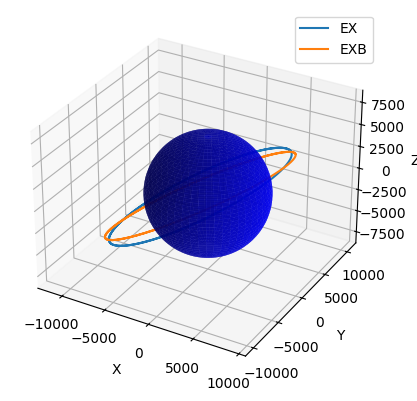

In [135]:
#plot EX and EXB position vectors in 3d with a sphere at 0, 0, 0 of radius Re
theta = np.linspace(0, 2*np.pi, 100)
phi = np.linspace(0, np.pi, 100)
theta, phi = np.meshgrid(theta, phi)

earth_x = Re * np.cos(theta)*np.sin(phi)
earth_y = Re * np.sin(theta) * np.sin(phi)
earth_z = Re * np.cos(phi)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(earth_x, earth_y, earth_z, color='b', alpha=0.8)
ax.plot(EX_state[0], EX_state[1], EX_state[2], label='EX')
ax.plot(EXB_state[0], EXB_state[1], EXB_state[2], label='EXB')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
ax.legend()
plt.show()

#Find Minimum Distance

In [136]:
from scipy.spatial.distance import cdist
x = []
y = []

for i in range(len(EX_state[0])):
  x.append(np.array([EX_state[0][i], EX_state[1][i], EX_state[2][i]]))
  y.append(np.array([EXB_state[0][i], EXB_state[1][i], EXB_state[2][i]]))

d = cdist(x,y)
darg = np.argmin(d)
el1min = darg // len(EX_state[0])
darg2 = np.argmin(d[el1min])

r_closestEX = np.array([EX_state[0][el1min], EX_state[1][el1min], EX_state[2][el1min]])
r_closestEXB = np.array([EXB_state[0][darg2], EXB_state[1][darg2], EXB_state[2][darg2]])

print(f"Closest EX Point: {r_closestEX}")
print(f"Closest EXB Point: {r_closestEXB}")

print(f"distance: {np.linalg.norm(r_closestEXB - r_closestEX)}")
t_closestEX = EX_t[el1min]
t_closestEXB = EXB_t[darg2]
print(f"Closest EX Time: {t_closestEX}")
print(f"Closest EXB Time: {t_closestEXB}")



Closest EX Point: [7741.28881644 1082.62413044 4493.88870462]
Closest EXB Point: [7821.74603841 1097.63782553 4587.60157452]
distance: 124.42217483644579
Closest EX Time: 9175.42593795782
Closest EXB Time: 9701.42498677173
